In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr8k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster', font_scale=1.75)
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mtambos/anaconda/envs/thesis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
cnn_model = mmsom.create_cnn_model()

In [4]:
alexnet = AlexNet(weights='../alexnet_weights.h5')

In [17]:
test_captions_fname = Path('/data/master_thesis/image_retrieval_flickr30k_word/test_captions.csv')
test_captions = pd.read_csv(test_captions_fname)
print(len(test_captions))
test_captions.head()

5000


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,caption_id,caption,fname
0,0.014374,0.006487,-0.042115,-0.058029,0.036493,-0.012606,0.017660,-0.003536,-0.027002,0.672071,...,-0.007479,-0.054052,0.024768,0.009723,-0.004624,-0.029254,0.039362,0,Workers are busy erecting scaffolding on the s...,/data/master_thesis/Flickr30k_Dataset/23845072...
1,0.007769,-0.003761,-0.044688,-0.053584,0.013478,-0.007328,0.021183,0.002066,0.025666,0.595120,...,-0.024272,-0.073400,0.019545,0.017496,-0.037832,-0.014197,-0.044824,1,"Four men are working with scaffolding , two ha...",/data/master_thesis/Flickr30k_Dataset/23845072...
2,0.006500,0.017829,-0.014951,-0.023215,0.033409,-0.005390,0.003044,0.007378,0.003112,0.596866,...,-0.006982,-0.041270,-0.024136,-0.012247,-0.011367,-0.056075,-0.035509,2,A four man construction crew is assembling sca...,/data/master_thesis/Flickr30k_Dataset/23845072...
3,0.030906,0.020851,-0.019435,-0.021689,0.018127,-0.031066,-0.005033,0.037364,0.030092,0.649415,...,-0.004811,-0.069716,-0.011067,0.005232,-0.017120,-0.014194,-0.015815,3,Four men next to campaign signs build red scaf...,/data/master_thesis/Flickr30k_Dataset/23845072...
4,-0.013861,-0.020805,-0.050314,-0.027570,0.036581,-0.009254,0.000782,-0.014671,0.032486,0.612675,...,0.018629,-0.035312,0.013951,-0.031299,-0.035975,-0.000521,-0.025029,4,four worker are constructing a scaffold .,/data/master_thesis/Flickr30k_Dataset/23845072...


In [14]:
train_captions_fname = Path('/data/master_thesis/image_retrieval_flickr30k_word/train_captions.csv')
train_captions = pd.read_csv(train_captions_fname)
print(len(train_captions))
train_captions.head()

153915


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,caption_id,caption,fname
0,0.025909,0.091360,-0.024112,-0.016339,0.074590,-0.040642,0.005571,0.013197,-0.020757,0.595413,...,-0.036797,-0.017296,-0.050454,0.008147,-0.006413,-0.027585,0.008764,0,"A boy in an orange "" Spring Hill "" ball team u...",/data/master_thesis/Flickr30k_Dataset/25623779...
1,0.008363,0.055345,-0.027528,0.018812,0.048597,-0.047171,0.001384,-0.030100,0.026930,0.618156,...,-0.038016,-0.012604,-0.011252,-0.003552,-0.048853,-0.031835,0.031282,1,A young boy in an orange uniform is pitching a...,/data/master_thesis/Flickr30k_Dataset/25623779...
2,0.018770,0.092797,-0.047928,0.021057,0.086467,-0.017530,0.016962,-0.028744,0.013961,0.602149,...,-0.038441,-0.036003,-0.025567,-0.002391,-0.053929,-0.022099,0.062876,2,a boy in an orange jersey is about to pitch a ...,/data/master_thesis/Flickr30k_Dataset/25623779...
3,-0.009878,0.069553,-0.036020,0.002777,0.040078,-0.029982,-0.002629,-0.026422,0.028954,0.583617,...,-0.024346,-0.021402,-0.002374,-0.007284,-0.053696,-0.033512,0.047205,3,A little boy in orange pitching at a baseball ...,/data/master_thesis/Flickr30k_Dataset/25623779...
4,0.014141,0.030602,-0.030120,-0.027690,0.029913,-0.024749,-0.013232,-0.004551,0.014751,0.581825,...,-0.050957,-0.042426,0.016473,0.008934,0.005710,-0.025280,0.054719,4,The boy in the orange shirt is throwing the ba...,/data/master_thesis/Flickr30k_Dataset/25623779...


In [19]:
len(train_captions.fname.value_counts())

30783

In [8]:
vec2img_test_fname = Path('vec2img_test.csv')
if vec2img_test_fname.exists():
    vec2img_test = pd.read_csv(vec2img_test_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_test = []
    for fname in tqdmn(set(test_captions.fname)):
        fname = img_dir / fname
        vec2img_test.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_test = pd.DataFrame(
        vec2img_test, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_test = vec2img_test.set_index('fname')
    vec2img_test.to_csv(vec2img_test_fname)
vec2img_test.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr30k_Dataset/4767559417.jpg,0.0,0.000000,0.0,5.008735,0.0,0.0,0.000000,0.000000,0.0,1.041347,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4.006299,0.0,0.000000,0.899785
/data/master_thesis/Flickr30k_Dataset/4520185597.jpg,0.0,0.000000,0.0,1.239906,0.0,0.0,1.499873,0.328968,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.543348,0.0,0.000000,0.000000
/data/master_thesis/Flickr30k_Dataset/3224375029.jpg,0.0,0.000000,0.0,0.000000,0.0,0.0,0.152723,0.000000,0.0,0.000000,...,0.000000,1.166568,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.462984,0.000000
/data/master_thesis/Flickr30k_Dataset/2315973850.jpg,0.0,0.000000,0.0,0.000000,0.0,0.0,0.918754,0.000000,0.0,1.717376,...,0.000000,0.327088,0.0,1.223651,0.0,0.000000,0.000000,0.0,0.000000,0.000000
/data/master_thesis/Flickr30k_Dataset/237424188.jpg,0.0,1.874337,0.0,0.809172,0.0,0.0,0.000000,0.022224,0.0,0.000000,...,0.449118,0.000000,0.0,0.000000,0.0,0.103672,0.000000,0.0,0.340089,0.916679


In [9]:
model = mmsom.MultimodalSOM()
model.load('som_planar_rectangular')

In [10]:
from sklearn.manifold import TSNE

projection = TSNE().fit_transform(model.som_model.codebook.reshape(10000, 4396))

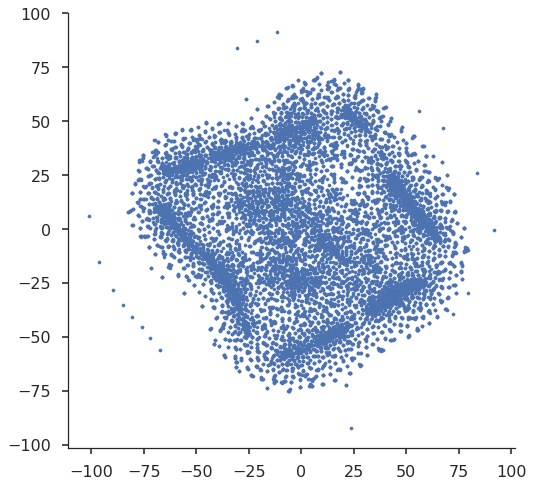

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(*projection.T, s=10)
sns.despine()

In [ ]:
ax = plt.figure(figsize=(16, 16)).gca()
knn_ids = model.get_knn_images(doc='dog water', k=4, vec2img=vec2img_test)
knn = vec2img_test.index[knn_ids]
fig_array = np.ones((2, 2, 224, 224, 3))
for i, fname in enumerate(knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    fig_array[i//2, i%2] = img

fig_array = fig_array.transpose(0, 2, 1, 3, 4).reshape(224*2, 224*2, 3)
ax.set_title('\n'.join(test_captions.loc[test_captions.fname.isin(knn.astype(str)), 'caption']),
             fontsize=12)
ax.imshow(fig_array)
sns.despine()
plt.tight_layout()

In [2]:
train_words_fname = Path('train_words.csv')
if train_words_fname.exists():
    train_words = pd.read_csv(train_words_fname)
else:
    train_words = []
    for _, row in tqdmn(train_captions.iterrows(), total=len(train_captions)):
        for word in set([w for w in map(str.strip, map(str.lower, row.caption.split()))
                         if nlp(w)[0].pos_ in ('NOUN', 'PROPN')]):
            train_words.append((row.fname, row.caption_id, word))
    train_words = pd.DataFrame(train_words, columns=('fname', 'doc_rank', 'word'))
    train_words = train_words.drop_duplicates().reset_index(drop=True)
    train_words.to_csv(train_words_fname, index=False)
print(len(train_words))
train_words.head()

530682


,fname,doc_rank,word
0,/data/master_thesis/Flickr30k_Dataset/25623779...,0,team
1,/data/master_thesis/Flickr30k_Dataset/25623779...,0,hill
2,/data/master_thesis/Flickr30k_Dataset/25623779...,0,uniform
3,/data/master_thesis/Flickr30k_Dataset/25623779...,0,boy
4,/data/master_thesis/Flickr30k_Dataset/25623779...,0,spring


In [3]:
test_words_fname = Path('test_words.csv')
if test_words_fname.exists():
    test_words = pd.read_csv(test_words_fname)
else:
    test_words = []
    for _, row in tqdmn(test_captions.iterrows(), total=len(test_captions)):
        for word in set([w for w in map(str.strip, map(str.lower, row.caption.split()))
                         if nlp(w)[0].pos_ in ('NOUN', 'PROPN')]):
            test_words.append((row.fname, row.caption_id, word))
    test_words = pd.DataFrame(test_words, columns=('fname', 'doc_rank', 'word'))
    test_words = test_words.drop_duplicates().reset_index(drop=True)
    test_words.to_csv(test_words_fname, index=False)
print(len(test_words))
test_words.head()

17391


,fname,doc_rank,word
0,/data/master_thesis/Flickr30k_Dataset/23845072...,0,workers
1,/data/master_thesis/Flickr30k_Dataset/23845072...,0,scaffolding
2,/data/master_thesis/Flickr30k_Dataset/23845072...,0,street
3,/data/master_thesis/Flickr30k_Dataset/23845072...,0,business
4,/data/master_thesis/Flickr30k_Dataset/23845072...,1,men


In [14]:
results_words = {}
for _, row in tqdmn(test_words.iterrows(), total=len(test_words)):
    fname, doc_rank, word = row
    knn_ids = model.get_knn_images(doc=word, k=20, vec2img=vec2img_test)
    knn = vec2img_test.index[knn_ids]
    results_words[(fname, doc_rank, word)] = knn.copy()
results_words

HBox(children=(IntProgress(value=0, max=17391), HTML(value='')))

multimodal_som:143: RuntimeWarning: invalid value encountered in true_divide


{('/data/master_thesis/Flickr30k_Dataset/2384507273.jpg',
  0,
  'workers'): Index(['/data/master_thesis/Flickr30k_Dataset/2542304168.jpg',
        '/data/master_thesis/Flickr30k_Dataset/4741320398.jpg',
        '/data/master_thesis/Flickr30k_Dataset/5418130134.jpg',
        '/data/master_thesis/Flickr30k_Dataset/2101729860.jpg',
        '/data/master_thesis/Flickr30k_Dataset/3286620180.jpg',
        '/data/master_thesis/Flickr30k_Dataset/157308126.jpg',
        '/data/master_thesis/Flickr30k_Dataset/5270958162.jpg',
        '/data/master_thesis/Flickr30k_Dataset/388604469.jpg',
        '/data/master_thesis/Flickr30k_Dataset/226539616.jpg',
        '/data/master_thesis/Flickr30k_Dataset/4928961144.jpg',
        '/data/master_thesis/Flickr30k_Dataset/4670289514.jpg',
        '/data/master_thesis/Flickr30k_Dataset/4928775496.jpg',
        '/data/master_thesis/Flickr30k_Dataset/228280436.jpg',
        '/data/master_thesis/Flickr30k_Dataset/4958945147.jpg',
        '/data/master_thesis/Fli

In [16]:
import pickle

with open('results_words.pickle', 'wb') as fp:
    pickle.dump(results_words, fp)

In [2]:
import pickle

with open('results_words.pickle', 'rb') as fp:
    results_words = pickle.load(fp)

In [3]:
np.mean([1 if Path(fname).name in r[:1].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.00546259559542292

In [4]:
np.mean([1 if Path(fname).name in r[:2].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.00908515899028233

In [5]:
np.mean([1 if Path(fname).name in r[:5].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.019435340118452073

In [6]:
np.mean([1 if Path(fname).name in r[:10].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.03214306250359381

In [7]:
np.mean([1 if Path(fname).name in r[:20].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, description), r in results_words.items()])

0.053648438847679836

# High-frequency words

In [4]:
test_word_counts = test_words.word.value_counts()
test_word_counts /= test_word_counts.sum()
train_word_counts = train_words.word.value_counts()
train_word_counts /= train_word_counts.sum()

display(train_word_counts.head(10))
print()
display(test_word_counts.head(10))

woman     0.039223
people    0.031209
shirt     0.022322
men       0.017176
girl      0.017108
boy       0.016826
dog       0.015278
street    0.014361
group     0.014167
water     0.010652
Name: word, dtype: float64

woman     0.039158
people    0.031396
shirt     0.022023
girl      0.017710
boy       0.015985
men       0.015985
street    0.015870
group     0.014893
dog       0.014778
water     0.010120
Name: word, dtype: float64

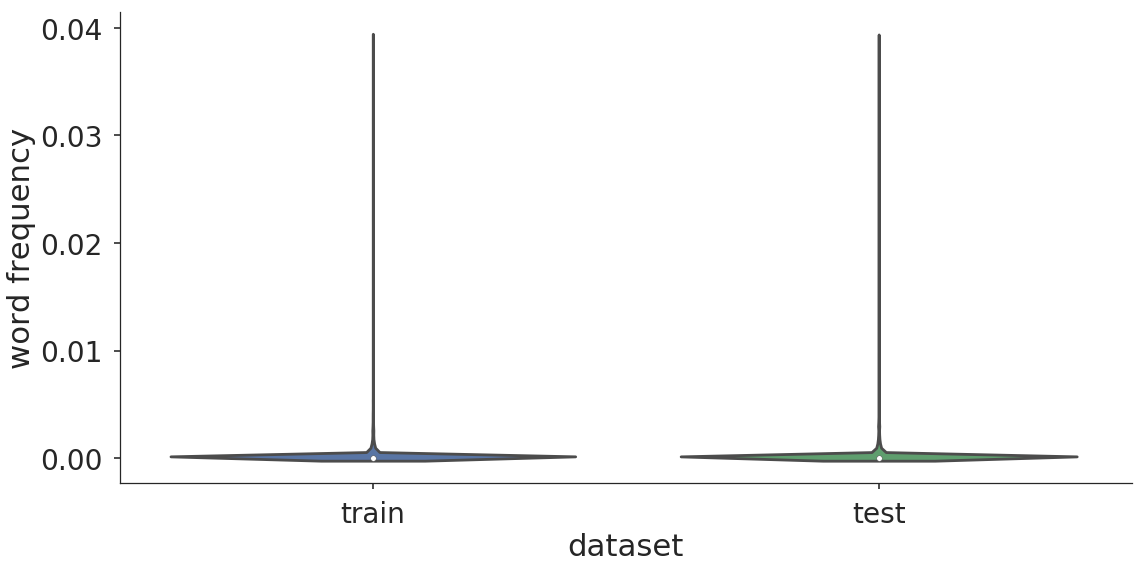

In [5]:
plt.figure(figsize=(16, 8))
word_counts = pd.concat([train_word_counts, test_word_counts], axis=1).fillna(0).reset_index()
word_counts.columns = ['word', 'train', 'test']
word_counts = pd.melt(word_counts, id_vars='word', value_vars=['train', 'test'], value_name='word frequency', var_name='dataset')
ax = sns.violinplot(data=word_counts, x='dataset', y='word frequency')
sns.despine()
plt.tight_layout()

In [151]:
hifreq_test_word_counts = test_word_counts[test_word_counts > np.percentile(test_word_counts, 95)]
print(len(test_word_counts), len(hifreq_test_word_counts))
hifreq_test_words = set(hifreq_test_word_counts.index)
hifreq_test_word_counts.head()

2257 111


woman     0.039158
people    0.031396
shirt     0.022023
girl      0.017710
boy       0.015985
Name: word, dtype: float64

In [157]:
hifreq_train_word_counts = train_word_counts[train_word_counts > np.percentile(train_word_counts, 95)]
print(len(train_word_counts), len(hifreq_train_word_counts))
hifreq_train_words = set(hifreq_train_word_counts.index)
hifreq_train_word_counts.head()

10946 548


woman     0.039223
people    0.031209
shirt     0.022322
men       0.017176
girl      0.017108
Name: word, dtype: float64

In [158]:
np.mean([1 if Path(fname).name in r[:1].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, word), r in results_words.items()
         if word in hifreq_train_words])

0.005124133949191686

In [159]:
np.mean([1 if Path(fname).name in r[:2].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, word), r in results_words.items()
         if word in hifreq_train_words])

0.008660508083140877

In [160]:
np.mean([1 if Path(fname).name in r[:5].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, word), r in results_words.items()
         if word in hifreq_train_words])

0.019413972286374134

In [161]:
np.mean([1 if Path(fname).name in r[:10].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, word), r in results_words.items()
         if word in hifreq_train_words])

0.0319717090069284

In [162]:
np.mean([1 if Path(fname).name in r[:20].map(lambda p: Path(p).name) else 0
         for (fname, doc_rank, word), r in results_words.items()
         if word in hifreq_train_words])

0.05261258660508083